In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.6.0+cu118
CUDA available: True


In [2]:
# === 1. Import libraries and setup ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
import time
import gc
import json
import warnings
warnings.filterwarnings('ignore')

# Setup device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache() # Attempt to clear cache
print(f"PyTorch Version: {torch.__version__}")
print("-" * 30)

Using device: cuda
Device name: NVIDIA GeForce RTX 4060 Laptop GPU
PyTorch Version: 2.6.0+cu118
------------------------------


In [3]:
# === 2. Data Loading, Preparation, Filtering ===
# --- Configuration ---
META_FILENAME = 'HAM10000_metadata'
IMG_DIR_PART1 = 'HAM10000_images_part_1'
IMG_DIR_PART2 = 'HAM10000_images_part_2'
CONSOLIDATED_IMG_DIR = 'HAM10000_images' # Final image directory relative to notebook

try:
    if not os.path.exists(META_FILENAME): raise FileNotFoundError(f"'{META_FILENAME}' not found.")
    df = pd.read_csv(META_FILENAME)
    print(f"Initial DataFrame shape: {df.shape}")

    # --- Consolidate images (copy) ---
    if not os.path.exists(CONSOLIDATED_IMG_DIR):
        print(f"Consolidating images into '{CONSOLIDATED_IMG_DIR}'...")
        os.makedirs(CONSOLIDATED_IMG_DIR)
        copied_count = 0
        for img_dir in [IMG_DIR_PART1, IMG_DIR_PART2]:
            if os.path.isdir(img_dir):
                print(f"Copying from {img_dir}...")
                file_list = os.listdir(img_dir)
                for i, img_file in enumerate(file_list):
                    src_path = os.path.join(img_dir, img_file); dst_path = os.path.join(CONSOLIDATED_IMG_DIR, img_file)
                    if not os.path.exists(dst_path): shutil.copy(src_path, dst_path); copied_count += 1
                    # Simple progress update without tqdm
                    if (i + 1) % 500 == 0 or (i + 1) == len(file_list):
                        print(f"  Copied {i+1}/{len(file_list)} from {os.path.basename(img_dir)}", end='\r')
                print(f"\nFinished copying from {img_dir}.") # Newline after progress
            # else: print(f"W: Source dir '{img_dir}' not found.")
        print(f"Image consolidation complete. Files copied: {copied_count}")
    else: print(f"Directory '{CONSOLIDATED_IMG_DIR}' already exists.")
    img_dir_str = CONSOLIDATED_IMG_DIR

    # --- Create and check image paths ---
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir_str, f"{x}.jpg"))
    df = df[df['image_path'].apply(os.path.exists)].copy()
    print(f"DataFrame shape after checking paths: {df.shape}")
    if df.empty: raise ValueError("No existing image paths found.")
    # --- Map names and Filter classes ---
    class_name_mapping = {
        'nv': 'Melanocytic_nevi', 'mel': 'Melanoma', 'bkl': 'Benign_keratosislike_lesions',
        'bcc': 'Basal_cell_carcinoma', 'akiec': 'Actinic_keratoses',
        'vasc': 'Vascular_lesions', 'df': 'Dermatofibroma'
    }
    df['dx_full'] = df['dx'].map(class_name_mapping)
    min_samples = 500
    class_counts = df['dx_full'].value_counts()
    classes_to_keep = class_counts[class_counts >= min_samples].index.tolist()
    df_filtered = df[df['dx_full'].isin(classes_to_keep)].copy()
    final_class_counts = df_filtered['dx_full'].value_counts()
    num_classes = len(final_class_counts) # Define num_classes *globally* for this script
    print(f"\nKept {num_classes} classes with >= {min_samples} samples:")
    print(final_class_counts)
    if num_classes == 0: raise ValueError("No classes left after filtering!")

    # --- Encode labels and store names ---
    le = LabelEncoder()
    df_filtered['label'] = le.fit_transform(df_filtered['dx'])
    class_names_short = list(le.classes_)
    idx_to_fullname_map = {idx: class_name_mapping.get(cls_short, cls_short) for idx, cls_short in enumerate(class_names_short)}
    report_target_names = [idx_to_fullname_map[i] for i in range(num_classes)] # Define report_target_names *globally*
    print("\nClass index to short name:", dict(enumerate(class_names_short)))
    print("Target names for reports:", report_target_names)

    # --- Split data ---
    train_df, temp_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
    print(f"\nSplit sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    # --- Clean up DataFrames ---
    del df, df_filtered, temp_df, class_counts, final_class_counts
    gc.collect()
    print("Original DataFrames cleaned up.")

except Exception as e:
    print(f"\n--- An error occurred during data preparation ---"); print(e); raise e
print("-" * 30)

Initial DataFrame shape: (10015, 8)
Directory 'HAM10000_images' already exists.
DataFrame shape after checking paths: (10015, 9)

Kept 4 classes with >= 500 samples:
dx_full
Melanocytic_nevi                6705
Melanoma                        1113
Benign_keratosislike_lesions    1099
Basal_cell_carcinoma             514
Name: count, dtype: int64

Class index to short name: {0: 'bcc', 1: 'bkl', 2: 'mel', 3: 'nv'}
Target names for reports: ['Basal_cell_carcinoma', 'Benign_keratosislike_lesions', 'Melanoma', 'Melanocytic_nevi']

Split sizes: Train=7544, Val=943, Test=944
Original DataFrames cleaned up.
------------------------------


In [4]:
# === 3. Dataset, Augmentations, DataLoader ===
IMG_SIZE = 224
BATCH_SIZE = 16 # Adjust based on VRAM!
NUM_WORKERS = 0 if os.name == 'nt' else min(os.cpu_count() // 2, 4)
print(f"Image Size: {IMG_SIZE}, Batch Size: {BATCH_SIZE}, Workers: {NUM_WORKERS}")

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# --- Transforms ---
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.RandomRotate90(p=0.5), A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), A.ShiftScaleRotate(p=0.7, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.5), A.HueSaturationValue(p=0.5),
    A.Normalize(mean=NORM_MEAN, std=NORM_STD), ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=NORM_MEAN, std=NORM_STD), ToTensorV2()
])
# --- Dataset Class ---
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe; self.transform = transform
        self.file_paths = self.df['image_path'].values; self.labels = self.df['label'].values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img_path=self.file_paths[idx]; image=None
        try:
            image_bgr=cv2.imread(img_path)
            if image_bgr is None: raise IOError(f"cv2.imread returned None for {img_path}")
            image=cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"W: Load/Cvt {img_path}: {e}. Fallback."); fallback_idx=(idx-1)%len(self) if len(self)>0 else 0
            if idx == fallback_idx:
                # Avoid infinite recursion if the fallback image also fails
                print(f"E: Fallback index {fallback_idx} is the same as original {idx} or dataset is empty. Returning None.")
                return None, None
            else:
                return self.__getitem__(fallback_idx)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            try: image=self.transform(image=image)['image']
            except Exception as e:
                print(f"W: transform {img_path}: {e}. Basic."); transform_fallback=A.Compose([A.Resize(IMG_SIZE,IMG_SIZE), A.Normalize(mean=NORM_MEAN,std=NORM_STD), ToTensorV2()])
                try: image=transform_fallback(image=image)['image']
                except Exception as fe: print(f"E: fallback transform {img_path}: {fe}"); return None,None
        # Ensure label is always returned, even if image failed transform
        if image is None:
            return None, None # Indicate failure
        return image, label
print("SkinDataset class defined.")

# --- Collate Function ---
def collate_fn_skip_none(batch):
    # Filter out items where either image or label is None (from dataset __getitem__)
    batch = list(filter(lambda x: x is not None and x[0] is not None and x[1] is not None, batch))
    if not batch:
        # print("W: Collate received an empty batch after filtering.")
        return None, None # Return None tuple if batch becomes empty
    try:
        # Proceed with default collation if batch is valid
        return torch.utils.data.dataloader.default_collate(batch)
    except Exception as e:
        print(f"E: Collate failed: {e}. Skipping batch.");
        return None, None # Return None tuple on collation error
print("Collate function defined.")

# --- Create Datasets & DataLoaders ---
try:
    train_dataset = SkinDataset(train_df, transform=train_transform)
    val_dataset = SkinDataset(val_df, transform=val_test_transform)
    test_dataset = SkinDataset(test_df, transform=val_test_transform)
    print(f"\nDatasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', drop_last=True, collate_fn=collate_fn_skip_none)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', collate_fn=collate_fn_skip_none)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', collate_fn=collate_fn_skip_none)
    print("DataLoaders created.")
    # Clean up immediately after use
    del train_df, val_df, test_df
    gc.collect()
    print("Split DataFrames cleaned up.")
except NameError as e: print(f"E: Creating Datasets/Loaders failed, likely due to DataFrame definition issues: {e}"); raise
except Exception as e: print(f"E: Creating Datasets/Loaders: {e}"); raise
print("-" * 30)

Image Size: 224, Batch Size: 16, Workers: 0
SkinDataset class defined.
Collate function defined.

Datasets created: Train=7544, Val=943, Test=944
DataLoaders created.
Split DataFrames cleaned up.
------------------------------


In [5]:
# === 4. Flexible Model Creation Function (UPDATED) ===
print("\n--- 4. Defining Model Creation Function ---")
def get_pytorch_model(model_name: str, num_classes: int, pretrained: bool = True):
    weights_arg = 'DEFAULT' if pretrained else None
    model = None
    print(f"Attempting to load model: {model_name} (pretrained={pretrained})")
    try:
        # Use a dictionary for cleaner mapping and easier extension
        model_loaders = {
            'efficientnet_b0': models.efficientnet_b0,
            'efficientnet_b2': models.efficientnet_b2,
            'efficientnet_b3': models.efficientnet_b3, # <-- ADDED
            'resnet50': models.resnet50,
            'densenet121': models.densenet121,
            'vit_b_16': models.vit_b_16,
            'convnext_tiny': models.convnext_tiny,
            'convnext_small': models.convnext_small, # <-- ADDED
        }

        if model_name not in model_loaders:
            raise ValueError(f"Model '{model_name}' not supported in this function.")

        # Special handling for ViT weights name if needed (seems 'DEFAULT' works now)
        # weights = models.ViT_B_16_Weights.DEFAULT if model_name=='vit_b_16' and pretrained else weights_arg
        # For simplicity, using 'DEFAULT' for all should work with recent torchvision
        weights = weights_arg

        # Load the model
        model = model_loaders[model_name](weights=weights)

        # Replace the classifier layer
        if model_name.startswith('efficientnet'):
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        elif model_name.startswith('resnet'):
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        elif model_name.startswith('densenet'):
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
        elif model_name.startswith('vit'):
            num_ftrs = model.heads.head.in_features
            model.heads.head = nn.Linear(num_ftrs, num_classes)
        elif model_name.startswith('convnext'):
            num_ftrs = model.classifier[2].in_features
            model.classifier[2] = nn.Linear(num_ftrs, num_classes)
        else:
            # Fallback attempt (might be incorrect)
            print(f"W: Unknown classifier structure for {model_name}. Attempting to replace last linear layer.")
            # Find the last linear layer and replace it
            last_layer_name = None
            for name, module in reversed(list(model.named_modules())):
                if isinstance(module, nn.Linear):
                    last_layer_name = name
                    break
            if last_layer_name:
                parent_name = '.'.join(last_layer_name.split('.')[:-1])
                layer_attr_name = last_layer_name.split('.')[-1]
                parent_module = dict(model.named_modules())[parent_name] if parent_name else model
                num_ftrs = getattr(parent_module, layer_attr_name).in_features
                setattr(parent_module, layer_attr_name, nn.Linear(num_ftrs, num_classes))
            else:
                raise TypeError(f"Could not automatically find linear layer to replace for {model_name}")

        print(f"Loaded {model_name} and replaced classifier for {num_classes} classes.")
        return model
    except Exception as e: print(f"Error loading model {model_name}: {e}"); raise
print("Model creation function defined (updated for effnet_b3, convnext_small).")
print("-" * 30)


--- 4. Defining Model Creation Function ---
Model creation function defined (updated for effnet_b3, convnext_small).
------------------------------


In [6]:
# === 5. Training and Validation Functions (without TQDM) ===
print("\n--- 5. Defining Training & Validation Functions ---")
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num, total_epochs):
    model.train(); running_loss = 0.0; correct_predictions = 0; total_samples = 0
    num_batches = len(dataloader)
    if num_batches == 0: print("W: Train dataloader is empty."); return 0.0, 0.0

    start_time_epoch = time.time() # Track epoch time
    processed_batches = 0
    for batch_idx, batch_data in enumerate(dataloader):
        # Skip if collate_fn returned None
        if batch_data is None or batch_data[0] is None or batch_data[1] is None:
            # print(f"W: Skipping None batch {batch_idx} in training.")
            continue
        inputs, labels = batch_data
        # Skip if batch is empty after potential filtering/errors
        if inputs.nelement() == 0 or labels.nelement() == 0:
            # print(f"W: Skipping empty batch {batch_idx} in training.")
            continue

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure output shape matches label shape before loss calculation
        if outputs.shape[0] != labels.shape[0]:
            print(f"W: Shape mismatch batch {batch_idx}: Out {outputs.shape}, Lbl {labels.shape}. Skip.")
            continue
        try:
            loss = criterion(outputs, labels)
            if torch.isnan(loss) or torch.isinf(loss):
                 print(f"W: NaN/Inf train loss batch {batch_idx}. Skip.")
                 continue # Skip backward/step if loss is invalid
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # loss.item() is avg loss for batch
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            processed_batches += 1

        except Exception as e:
            print(f"E: Training batch {batch_idx} failed: {e}. Skipping batch.")
            continue # Skip to next batch on error

        # Simple progress print
        if (batch_idx + 1) % (max(1, num_batches // 5)) == 0 or batch_idx == num_batches - 1:
            elapsed_time = time.time() - start_time_epoch
            eta = (elapsed_time / (batch_idx + 1)) * (num_batches - (batch_idx + 1)) if batch_idx + 1 > 0 else 0
            print(f"  Train Epoch {epoch_num}/{total_epochs} Batch {batch_idx+1}/{num_batches} | ETA: {eta:.0f}s", end='\r')

    print() # Newline after epoch progress
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    epoch_duration = time.time() - start_time_epoch
    print(f"  Train Epoch {epoch_num} took {epoch_duration:.2f}s. Processed batches: {processed_batches}/{num_batches}")
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device, epoch_num, total_epochs):
    model.eval(); running_loss = 0.0; correct_predictions = 0; total_samples = 0
    num_batches = len(dataloader)
    if num_batches == 0: print("W: Validation dataloader is empty."); return 0.0, 0.0

    start_time_epoch = time.time() # Track epoch time
    processed_batches = 0
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(dataloader):
            # Skip if collate_fn returned None
            if batch_data is None or batch_data[0] is None or batch_data[1] is None:
                # print(f"W: Skipping None batch {batch_idx} in validation.")
                continue
            inputs, labels = batch_data
            # Skip if batch is empty
            if inputs.nelement() == 0 or labels.nelement() == 0:
                # print(f"W: Skipping empty batch {batch_idx} in validation.")
                continue

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if outputs.shape[0] != labels.shape[0]:
                 print(f"W: Shape mismatch valid batch {batch_idx}: Out {outputs.shape}, Lbl {labels.shape}. Skip.")
                 continue

            try:
                loss = criterion(outputs, labels)
                if not (torch.isnan(loss) or torch.isinf(loss)):
                    running_loss += loss.item() * inputs.size(0)
                else:
                    print(f"W: NaN/Inf validation loss batch {batch_idx}.") # Log but don't stop validation

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                processed_batches += 1
            except Exception as e:
                 print(f"E: Validation batch {batch_idx} failed: {e}. Skipping batch.")
                 continue # Skip to next batch

            if (batch_idx + 1) % (max(1, num_batches // 2)) == 0 or batch_idx == num_batches - 1:
                 print(f"  Valid Epoch {epoch_num}/{total_epochs} Batch {batch_idx+1}/{num_batches}", end='\r')

    print() # Newline after epoch progress
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    epoch_duration = time.time() - start_time_epoch
    print(f"  Valid Epoch {epoch_num} took {epoch_duration:.2f}s. Processed batches: {processed_batches}/{num_batches}")
    return epoch_loss, epoch_acc
print("Training and validation functions defined.")
print("-" * 30)


--- 5. Defining Training & Validation Functions ---
Training and validation functions defined.
------------------------------


In [7]:
# === 6. Evaluation and Visualization Function ===
# plot_history_torch_robust remains the same as in your original code
def plot_history_torch_robust(history1, history2=None):
    h1=history1 if isinstance(history1,dict) else {}; h2=history2 if isinstance(history2,dict) else {}
    acc1=list(h1.get('train_acc',[])); val_acc1=list(h1.get('val_acc',[])); loss1=list(h1.get('train_loss',[])); val_loss1=list(h1.get('val_loss',[])); epochs1_count=len(acc1)
    acc2=list(h2.get('train_acc',[])); val_acc2=list(h2.get('val_acc',[])); loss2=list(h2.get('train_loss',[])); val_loss2=list(h2.get('val_loss',[])); epochs2_count=len(acc2); h2_present=False
    if epochs2_count > 0: acc_tot=acc1+acc2; val_acc_tot=val_acc1+val_acc2; loss_tot=loss1+loss2; val_loss_tot=val_loss1+val_loss2; h2_present=True
    else: acc_tot=acc1; val_acc_tot=val_acc1; loss_tot=loss1; val_loss_tot=val_loss1
    epochs_range=range(1,len(acc_tot)+1)
    if not epochs_range: print("No history data."); return
    plt.figure(figsize=(14,6)); plt.subplot(1,2,1); plt.plot(epochs_range,acc_tot,'b-',label='Train Acc'); plt.plot(epochs_range,val_acc_tot,'r-',label='Val Acc')
    if h2_present and epochs1_count>0: plt.axvline(x=epochs1_count, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.ylim(bottom=0); plt.xlim(left=0,right=len(acc_tot)+1); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(epochs_range,loss_tot,'b-',label='Train Loss'); plt.plot(epochs_range,val_loss_tot,'r-',label='Val Loss')
    if h2_present and epochs1_count>0: plt.axvline(x=epochs1_count, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.ylim(bottom=0); plt.xlim(left=0,right=len(acc_tot)+1); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
    
# evaluate_and_visualize remains mostly the same
def evaluate_and_visualize(model_name, history_stage1, history_stage2, model, test_loader, criterion, device, report_target_names, num_classes):
    print(f"\n--- Plotting History for {model_name} ---")
    plot_history_torch_robust(history_stage1, history_stage2)

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    if test_loader and model:
        model.eval(); all_labels=[]; all_preds=[]; test_loss_sum=0.0; total_test_samples=0
        # Use criterion if available and valid
        criterion_available = criterion is not None
        processed_batches = 0

        with torch.no_grad():
            num_test_batches = len(test_loader)
            for batch_idx, batch_data in enumerate(test_loader):
                # Skip None/empty batches
                if batch_data is None or batch_data[0] is None or batch_data[1] is None: continue
                inputs, labels = batch_data
                if inputs.nelement() == 0 or labels.nelement() == 0: continue

                inputs, labels = inputs.to(device), labels.to(device)
                try:
                    outputs = model(inputs)
                    if outputs.shape[0] != labels.shape[0]:
                         print(f"W: Shape mismatch test batch {batch_idx}. Skip.")
                         continue

                    if criterion_available:
                        try:
                             loss=criterion(outputs, labels)
                             if not (torch.isnan(loss) or torch.isinf(loss)):
                                 test_loss_sum += loss.item() * inputs.size(0)
                             else:
                                 print(f"W: NaN/Inf test loss batch {batch_idx}.")
                        except Exception as loss_e:
                            print(f"W: Criterion failed during test batch {batch_idx}: {loss_e}. Disabling loss calculation for rest.")
                            criterion_available=False # Stop trying if error

                    _, predicted=torch.max(outputs, 1)
                    total_test_samples += labels.size(0)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(predicted.cpu().numpy())
                    processed_batches += 1

                except Exception as eval_e:
                     print(f"E: Evaluation batch {batch_idx} failed: {eval_e}. Skipping.")
                     continue # Skip batch on model forward pass error

                if (batch_idx + 1) % (max(1, num_test_batches // 2)) == 0 or batch_idx == num_test_batches - 1:
                     print(f"  Test Batch {batch_idx+1}/{num_test_batches}", end='\r')
        print() # Newline
        print(f"  Test Evaluation: Processed batches: {processed_batches}/{num_test_batches}")

        if total_test_samples > 0:
            # Calculate metrics only if samples were processed
            test_loss = test_loss_sum / total_test_samples if criterion_available else float('nan')
            # Ensure all_labels and all_preds are not empty before calculating accuracy etc.
            if all_labels and all_preds:
                 test_acc = sum(1 for t,p in zip(all_labels,all_preds) if t==p) / total_test_samples
                 print(f"\nTest Loss ({model_name}): {test_loss:.4f}"); print(f"Test Accuracy ({model_name}): {test_acc:.4f}")
                 print(f"Target accuracy (> 0.85) {'achieved' if test_acc > 0.85 else 'NOT achieved'}")
                 print("\nClassification Report:"); print(classification_report(all_labels, all_preds, target_names=report_target_names, digits=4, zero_division=0))
                 print("\nConfusion Matrix:"); cm = confusion_matrix(all_labels, all_preds)
                 plt.figure(figsize=(max(6, num_classes*1.5), max(5, num_classes*1.2)));
                 sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=report_target_names, yticklabels=report_target_names)
                 plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix - {model_name}');
                 plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()
                 # Store results
                 return {'test_loss': test_loss, 'test_acc': test_acc}
            else:
                 print("W: No predictions collected, cannot generate report/matrix.")
                 return {'test_loss': test_loss, 'test_acc': float('nan')} # Return loss if calculated, nan acc
        else:
            print("No samples processed in test set.")
            return None
    else:
        print("Test loader or model not available.")
        return None
print("Evaluation and visualization function defined.")
print("-" * 30)

Evaluation and visualization function defined.
------------------------------


In [8]:
# === 7. Setup for Training (Common variables) ===
print("\n--- 7. Setup for Training Runs ---")
# Define variables needed in the next cell, even if not used here.
# --- Output Directory ---
WEIGHTS_DIR = "trained_model_weights"
os.makedirs(WEIGHTS_DIR, exist_ok=True)
print(f"Model weights directory: {WEIGHTS_DIR}")

# --- Results Dictionary (Initialize or ensure exists) ---
# Check if it exists from a previous run in the same kernel session, otherwise create
if 'all_results' not in locals():
    all_results = {}
    print("Initialized 'all_results' dictionary.")
else:
    print("'all_results' dictionary already exists. New results will be added.")

# --- Base Loss Function Setup (Weighted CE) ---
# Define the base criterion here so it's available for the next cell if needed
try:
    print(f"\nSetting up Base Loss Function...")
    y_train_encoded = train_dataset.labels # Assumes train_dataset is defined
    unique_labels = np.unique(y_train_encoded)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=y_train_encoded)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    # This is the 'base' criterion, the next cell might override it locally
    criterion_base = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Base Loss: Weighted CrossEntropyLoss. Weights: {class_weights_tensor.cpu().numpy().round(4)}")
except NameError:
     print("W: 'train_dataset' not defined, cannot compute class weights. Setting base criterion to standard CE.")
     criterion_base = nn.CrossEntropyLoss()
except Exception as e:
     print(f"E: Setting up base criterion failed: {e}. Setting base criterion to standard CE.")
     criterion_base = nn.CrossEntropyLoss()

print("\n--- Preparation Cell Finished ---")
print("Ensure all necessary variables like data loaders, num_classes, device, etc. are defined.")
print("You can now run the next cell to train the additional models.")


--- 7. Setup for Training Runs ---
Model weights directory: trained_model_weights
Initialized 'all_results' dictionary.

Setting up Base Loss Function...
Base Loss: Weighted CrossEntropyLoss. Weights: [4.5888 2.1456 2.1191 0.3516]

--- Preparation Cell Finished ---
Ensure all necessary variables like data loaders, num_classes, device, etc. are defined.
You can now run the next cell to train the additional models.


In [9]:
# === VERIFICATION BLOCK (ADD AT THE END OF CELL 1) ===
vars_to_check = {
    'device': 'torch.device',
    'num_classes': 'int',
    'train_loader': 'torch.utils.data.DataLoader',
    'val_loader': 'torch.utils.data.DataLoader',
    'test_loader': 'torch.utils.data.DataLoader',
    'WEIGHTS_DIR': 'str',
    'all_results': 'dict',
    'report_target_names': 'list',
    'criterion_base': 'torch.nn.modules.loss._WeightedLoss', # Or _Loss if no weights
    'get_pytorch_model': 'function',
    'train_one_epoch': 'function',
    'validate_one_epoch': 'function',
    'evaluate_and_visualize': 'function',
    'nn': 'module',
    'pd': 'module',
    'os': 'module',
}
all_defined = True
for var_name, expected_type_part in vars_to_check.items():
    if var_name in locals():
        actual_type = str(type(locals()[var_name]))
        # Simple check if expected type string is part of actual type string
        if expected_type_part in actual_type:
             print(f"  [OK] {var_name} defined. Type: {actual_type}")
        else:
             print(f"  [WARN] {var_name} defined, but type mismatch. Expected ~'{expected_type_part}', Got: {actual_type}")
    else:
        print(f"  [ERROR] {var_name} IS NOT DEFINED!")
        all_defined = False

if all_defined:
    print("--- Verification Passed: All key variables seem defined in Cell 1. ---")
else:
    print("--- !!! Verification FAILED: Some key variables were NOT defined in Cell 1!!! ---")
# === END OF VERIFICATION BLOCK ===

  [OK] device defined. Type: <class 'torch.device'>
  [OK] num_classes defined. Type: <class 'int'>
  [WARN] train_loader defined, but type mismatch. Expected ~'torch.utils.data.DataLoader', Got: <class 'torch.utils.data.dataloader.DataLoader'>
  [WARN] val_loader defined, but type mismatch. Expected ~'torch.utils.data.DataLoader', Got: <class 'torch.utils.data.dataloader.DataLoader'>
  [WARN] test_loader defined, but type mismatch. Expected ~'torch.utils.data.DataLoader', Got: <class 'torch.utils.data.dataloader.DataLoader'>
  [OK] WEIGHTS_DIR defined. Type: <class 'str'>
  [OK] all_results defined. Type: <class 'dict'>
  [OK] report_target_names defined. Type: <class 'list'>
  [WARN] criterion_base defined, but type mismatch. Expected ~'torch.nn.modules.loss._WeightedLoss', Got: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
  [OK] get_pytorch_model defined. Type: <class 'function'>
  [OK] train_one_epoch defined. Type: <class 'function'>
  [OK] validate_one_epoch defined. Type: <c


--- Starting Training for EfficientNet-B3 & ConvNeXt Small ---
Models to train in this run: ['efficientnet_b3', 'convnext_small']

Base Hyperparameters (defaults):
  Stage 1 Epochs: 30, LR: 0.001, ES Patience: 10
  Stage 2 Epochs: 30, ES Patience: 10
  Scheduler Patience: 5
Checked required variables - OK.

========================= Training: efficientnet_b3 =========================
Attempting to load model: efficientnet_b3
Attempting to load model: efficientnet_b3 (pretrained=True)
Loaded efficientnet_b3 and replaced classifier for 4 classes.
Model efficientnet_b3 loaded successfully.

Configuring settings for efficientnet_b3...
Applying settings based on B0 log analysis for EfficientNet-B3...
  Stage 1: Strategy=full_model, Epochs=30, LR=0.001
  Stage 2: Optim=Adam, LR=1e-05, WD=0.0, Epochs=30
  Loss: Label Smoothing=0.0
  Patience: Sched=5, ES_S1=10, ES_S2=10

Setting up Loss function for efficientnet_b3...
Using base loss function (No Label Smoothing).
  Loss function type: <clas

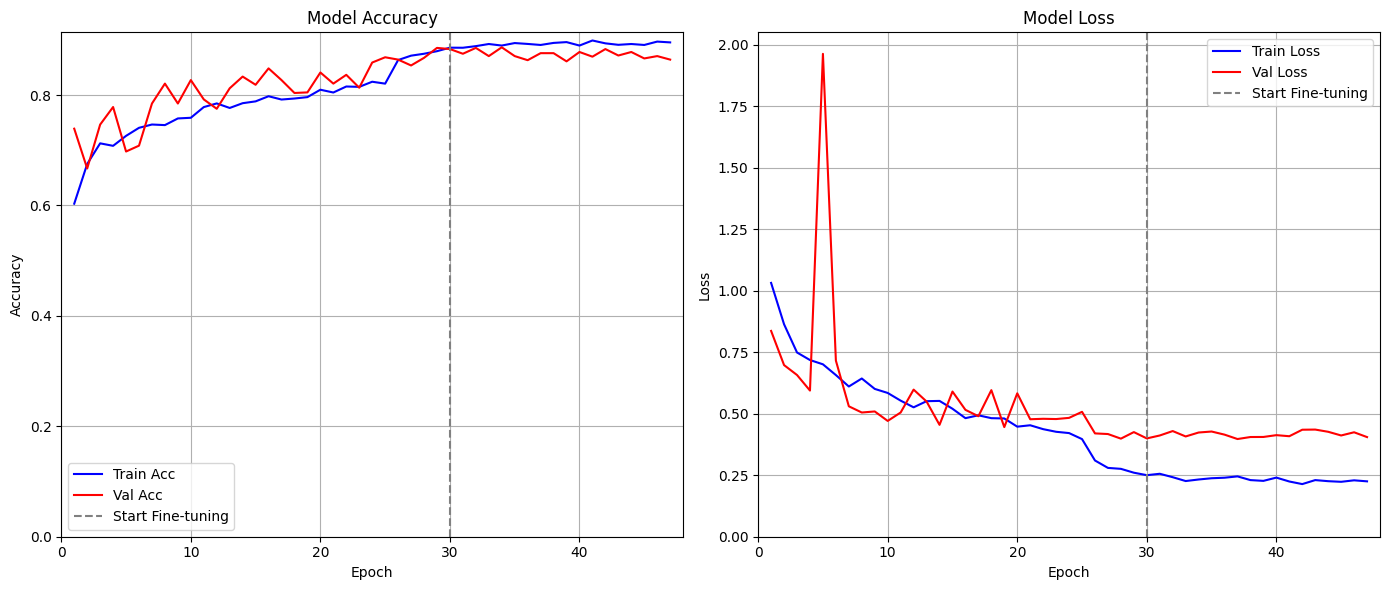


--- Evaluating efficientnet_b3 on Test Set ---
  Test Batch 59/59
  Test Evaluation: Processed batches: 59/59

Test Loss (efficientnet_b3): 0.4212
Test Accuracy (efficientnet_b3): 0.8718
Target accuracy (> 0.85) achieved

Classification Report:
                              precision    recall  f1-score   support

        Basal_cell_carcinoma     0.7143    0.8824    0.7895        51
Benign_keratosislike_lesions     0.7348    0.8818    0.8017       110
                    Melanoma     0.6301    0.8214    0.7132       112
            Melanocytic_nevi     0.9768    0.8778    0.9246       671

                    accuracy                         0.8718       944
                   macro avg     0.7640    0.8658    0.8072       944
                weighted avg     0.8933    0.8718    0.8779       944


Confusion Matrix:


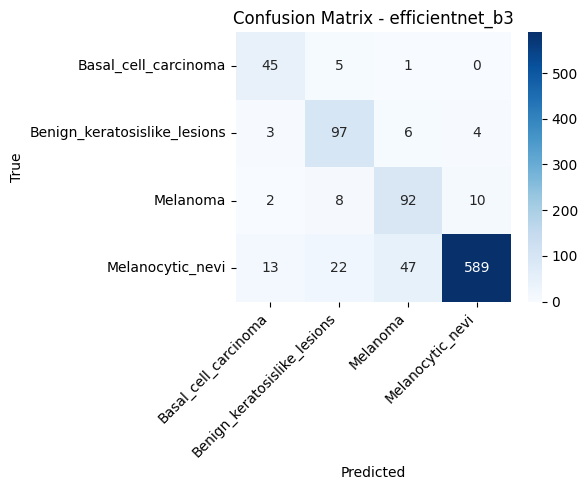

Results for efficientnet_b3 stored/updated in 'all_results'.

Cleaning up resources for efficientnet_b3...

Finished processing model efficientnet_b3 in 143.65 minutes.
------------------------------------------------------------

========================= Training: convnext_small =========================
Attempting to load model: convnext_small
Attempting to load model: convnext_small (pretrained=True)
Loaded convnext_small and replaced classifier for 4 classes.
Model convnext_small loaded successfully.

Configuring settings for convnext_small...
Applying recommended fine-tuning settings for ConvNeXt Small...
  Stage 1: Strategy=head_only, Epochs=30, LR=0.001
  Stage 2: Optim=AdamW, LR=5e-06, WD=0.05, Epochs=30
  Loss: Label Smoothing=0.1
  Patience: Sched=5, ES_S1=10, ES_S2=10

Setting up Loss function for convnext_small...
Using Label Smoothing (factor=0.1).
Attempting to use class weights WITH label smoothing.
  Loss function type: <class 'torch.nn.modules.loss.CrossEntropyLoss'>


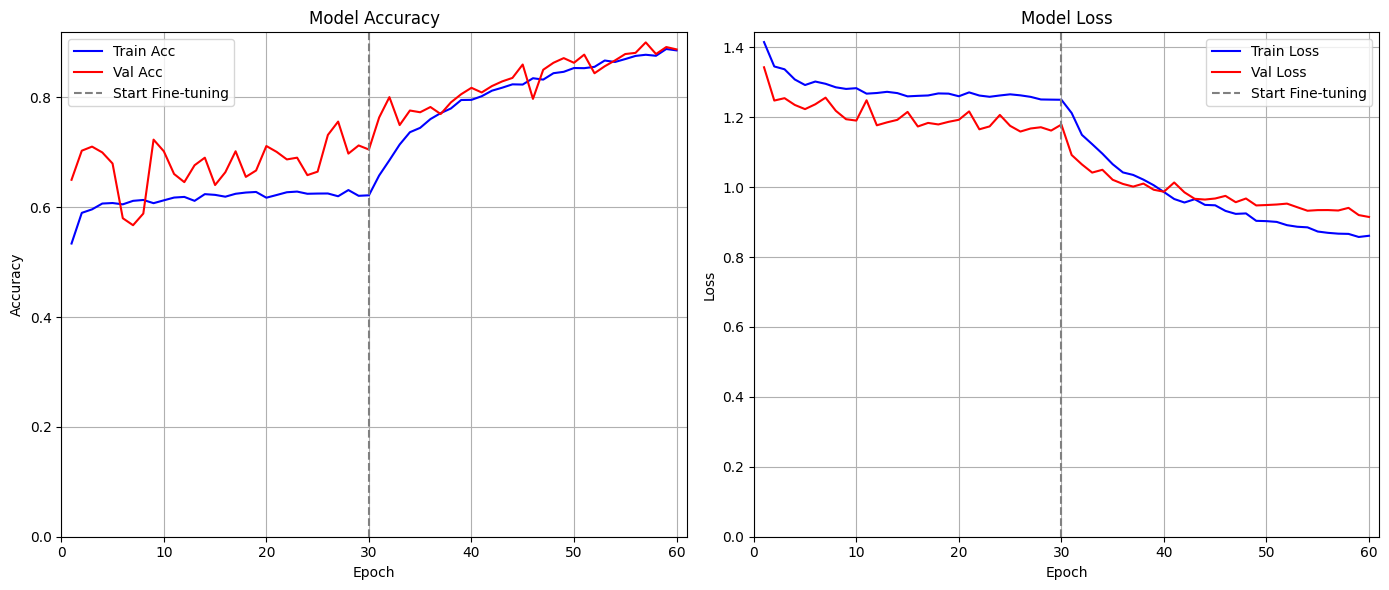


--- Evaluating convnext_small on Test Set ---
  Test Batch 59/59
  Test Evaluation: Processed batches: 59/59

Test Loss (convnext_small): 0.9164
Test Accuracy (convnext_small): 0.8750
Target accuracy (> 0.85) achieved

Classification Report:
                              precision    recall  f1-score   support

        Basal_cell_carcinoma     0.6571    0.9020    0.7603        51
Benign_keratosislike_lesions     0.8034    0.8545    0.8282       110
                    Melanoma     0.6289    0.8929    0.7380       112
            Melanocytic_nevi     0.9799    0.8733    0.9236       671

                    accuracy                         0.8750       944
                   macro avg     0.7674    0.8807    0.8125       944
                weighted avg     0.9003    0.8750    0.8816       944


Confusion Matrix:


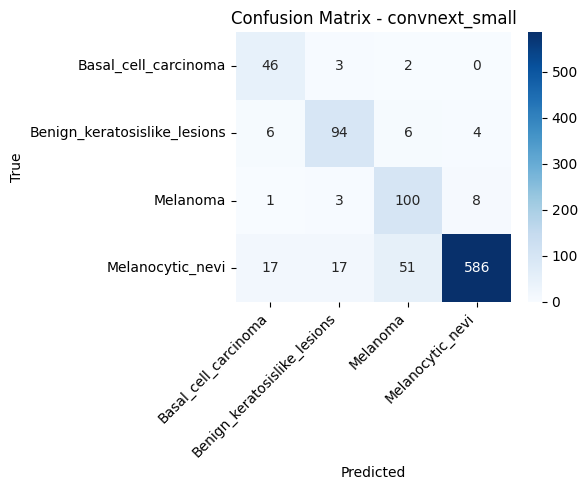

Results for convnext_small stored/updated in 'all_results'.

Cleaning up resources for convnext_small...

Finished processing model convnext_small in 223.59 minutes.
------------------------------------------------------------


In [13]:
# training

import torch.optim as optim

print("\n--- Starting Training for EfficientNet-B3 & ConvNeXt Small ---")

# --- Models to train in this run ---
model_names_to_train = [
    'efficientnet_b3',
    'convnext_small',
]
print(f"Models to train in this run: {model_names_to_train}")

# --- Base Hyperparameters (can be overridden per model) ---
# These might be common, but we'll set specifics inside the loop
BASE_EPOCHS_STAGE1 = 30
BASE_EPOCHS_STAGE2 = 30
BASE_INITIAL_LR_S1 = 1e-3
BASE_PATIENCE_S1 = 10
BASE_PATIENCE_S2 = 10
BASE_SCHEDULER_PATIENCE = 5

print(f"\nBase Hyperparameters (defaults):")
print(f"  Stage 1 Epochs: {BASE_EPOCHS_STAGE1}, LR: {BASE_INITIAL_LR_S1}, ES Patience: {BASE_PATIENCE_S1}")
print(f"  Stage 2 Epochs: {BASE_EPOCHS_STAGE2}, ES Patience: {BASE_PATIENCE_S2}")
print(f"  Scheduler Patience: {BASE_SCHEDULER_PATIENCE}")

# --- Check essential variables ---
required_vars = ['device', 'num_classes', 'train_loader', 'val_loader', 'test_loader',
                 'WEIGHTS_DIR', 'all_results', 'report_target_names', 'criterion_base',
                 'get_pytorch_model', 'train_one_epoch', 'validate_one_epoch',
                 'evaluate_and_visualize', 'nn', 'gc', 'os', 'time', 'np', 'pd']

missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"Required variables missing from Cell 1: {missing_vars}. Ensure Cell 1 was executed.")
else:
    print("Checked required variables - OK.")

# --- Loop for Training Multiple Models ---
for model_name in model_names_to_train:
    print(f"\n{'='*25} Training: {model_name} {'='*25}")
    start_time_model = time.time()
    gc.collect()
    if device.type == 'cuda': torch.cuda.empty_cache()

    # A. Create model
    try:
        print(f"Attempting to load model: {model_name}")
        current_model = get_pytorch_model(model_name, num_classes=num_classes, pretrained=True)
        current_model = current_model.to(device)
        print(f"Model {model_name} loaded successfully.")
    except Exception as e:
        print(f"E: Failed to create model {model_name}: {e}. Skipping model.")
        continue # Skip to the next model in the list

    # --- B. Model-Specific Settings ---
    print(f"\nConfiguring settings for {model_name}...")
    # Defaults from Base Hyperparameters
    epochs_s1 = BASE_EPOCHS_STAGE1
    epochs_s2 = BASE_EPOCHS_STAGE2
    initial_lr_s1 = BASE_INITIAL_LR_S1
    patience_s1 = BASE_PATIENCE_S1
    patience_s2 = BASE_PATIENCE_S2
    scheduler_patience = BASE_SCHEDULER_PATIENCE
    stage1_strategy = 'head_only' # Default: train only head in Stage 1
    label_smoothing = 0.0       # Default: no label smoothing
    fine_tune_lr_s2 = 1e-5      # Default fine-tune LR
    fine_tune_optimizer_type = 'Adam' # Default fine-tune optimizer
    fine_tune_weight_decay = 0.0 # Default fine-tune WD

    # --- Settings for EfficientNet-B3 (based on B0 log) ---
    if model_name == 'efficientnet_b3':
        print("Applying settings based on B0 log analysis for EfficientNet-B3...")
        stage1_strategy = 'full_model' # Replicating B0 assumption
        fine_tune_lr_s2 = 1e-5         # From B0 log
        fine_tune_optimizer_type = 'Adam'
        fine_tune_weight_decay = 0.0
        label_smoothing = 0.0
        # Epochs/Patience already match BASE defaults derived from B0

    # --- Settings for ConvNeXt Small (Best Practices) ---
    elif model_name == 'convnext_small':
        print("Applying recommended fine-tuning settings for ConvNeXt Small...")
        stage1_strategy = 'head_only'  # Standard practice
        fine_tune_lr_s2 = 5e-6         # Lower LR common for ConvNeXt/ViT
        fine_tune_optimizer_type = 'AdamW' # Recommended for ConvNeXt
        fine_tune_weight_decay = 0.05  # Common WD value for AdamW + ConvNeXt
        label_smoothing = 0.1          # Often beneficial
        # Keep Base Epochs/Patience for now, adjust later if needed

    print(f"  Stage 1: Strategy={stage1_strategy}, Epochs={epochs_s1}, LR={initial_lr_s1}")
    print(f"  Stage 2: Optim={fine_tune_optimizer_type}, LR={fine_tune_lr_s2}, WD={fine_tune_weight_decay}, Epochs={epochs_s2}")
    print(f"  Loss: Label Smoothing={label_smoothing}")
    print(f"  Patience: Sched={scheduler_patience}, ES_S1={patience_s1}, ES_S2={patience_s2}")

    # --- C. Setup Loss Function ---
    print(f"\nSetting up Loss function for {model_name}...")
    if label_smoothing > 0.0:
        print(f"Using Label Smoothing (factor={label_smoothing}).")
        try:
             weights = criterion_base.weight if hasattr(criterion_base, 'weight') else None
             if weights is not None: print("Attempting to use class weights WITH label smoothing.")
             else: print("No class weights found in criterion_base, using label smoothing without weights.")
             criterion_local = nn.CrossEntropyLoss(label_smoothing=label_smoothing, weight=weights).to(device)
        except Exception as ls_e:
             print(f"W: Failed to create LS loss with weights ({ls_e}). Falling back to LS without weights.")
             criterion_local = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(device)
    else:
        print("Using base loss function (No Label Smoothing).")
        criterion_local = criterion_base # Use the one defined in Cell 1 (Weighted CE)
    print(f"  Loss function type: {type(criterion_local)}")


    # --- D. Setup Optimizer & Scheduler (Stage 1) ---
    print("\nSetting up Optimizer/Scheduler for Stage 1...")
    optimizer_s1 = None
    try:
        params_s1 = None
        if stage1_strategy == 'head_only':
            print("Freezing base model layers for Stage 1 (head training only)...")
            for param in current_model.parameters():
                param.requires_grad = False

            # Unfreeze the appropriate classifier layer(s)
            unfrozen_params_count = 0
            if model_name.startswith('efficientnet'):
                classifier_module = current_model.classifier
            elif model_name.startswith('convnext'):
                classifier_module = current_model.classifier
            elif model_name.startswith('resnet'):
                 classifier_module = current_model.fc
            elif model_name.startswith('densenet'):
                 classifier_module = current_model.classifier
            # Add elif for other architectures if needed (e.g., ViT)
            # elif model_name.startswith('vit'):
            #      classifier_module = current_model.heads
            else:
                print(f"W: Unknown classifier structure for {model_name}. Attempting to unfreeze LAST module.")
                # Fallback: Get the very last module
                last_module_name, last_module = list(current_model.named_modules())[-1]
                classifier_module = last_module
                print(f"  Assuming last module '{last_module_name}' ({type(last_module)}) is the classifier.")

            if classifier_module is not None:
                 for param in classifier_module.parameters():
                    param.requires_grad = True
                    unfrozen_params_count += 1
                 print(f"Unfroze {unfrozen_params_count} parameters in the classifier.")
            else:
                 raise ValueError(f"Could not identify classifier module for {model_name} to unfreeze.")

            if unfrozen_params_count == 0:
                 raise ValueError(f"No parameters were unfrozen for Stage 1 head training for model {model_name}.")

            params_s1 = filter(lambda p: p.requires_grad, current_model.parameters())
            optimizer_s1 = optim.Adam(params_s1, lr=initial_lr_s1)
            print(f"Optimizer Stage 1: Adam lr={initial_lr_s1} (Training HEAD ONLY)")

        elif stage1_strategy == 'full_model':
            print("INFO: Stage 1 strategy is 'full_model'. Training ALL layers.")
            # Ensure all params require grad (might be redundant if model is freshly loaded)
            for param in current_model.parameters():
                param.requires_grad = True
            params_s1 = current_model.parameters()
            optimizer_s1 = optim.Adam(params_s1, lr=initial_lr_s1)
            print(f"Optimizer Stage 1: Adam lr={initial_lr_s1} (Training ALL layers)")
        else:
            raise ValueError(f"Unknown stage1_strategy: {stage1_strategy}")

        scheduler_s1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s1, mode='min', factor=0.2,
                                                          patience=scheduler_patience, verbose=True)

    except Exception as optim_e:
        print(f"E: Failed to setup Stage 1 optimizer for {model_name}: {optim_e}. Skipping model training.")
        del current_model # Clean up model object if optimizer setup fails
        if device.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
        continue # Skip to next model in the main loop

    # --- E. Stage 1 Training Loop ---
    history_s1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss_s1 = float('inf')
    patience_counter_s1 = 0
    weights_path_s1 = os.path.join(WEIGHTS_DIR, f'{model_name}_stage1.pth') # Unique name per model
    num_epochs_s1_actual = 0

    print(f"\n--- Stage 1: Training {model_name} (Max {epochs_s1} epochs) ---")
    try:
        for epoch in range(epochs_s1):
            epoch_num = epoch + 1
            print(f"\nStarting Stage 1 Epoch {epoch_num}/{epochs_s1}...")
            train_loss, train_acc = train_one_epoch(current_model, train_loader, criterion_local, optimizer_s1, device, epoch_num, epochs_s1)
            val_loss, val_acc = validate_one_epoch(current_model, val_loader, criterion_local, device, epoch_num, epochs_s1)

            if np.isnan(val_loss) or np.isinf(val_loss) or np.isnan(val_acc) or np.isinf(val_acc):
                print(f"W: Invalid validation metrics Epoch {epoch_num} (Loss: {val_loss}, Acc: {val_acc}). Stopping Stage 1 early.")
                break

            history_s1['train_loss'].append(train_loss); history_s1['train_acc'].append(train_acc)
            history_s1['val_loss'].append(val_loss); history_s1['val_acc'].append(val_acc)
            num_epochs_s1_actual += 1

            print(f"Epoch {epoch_num} Summary: Tr L:{train_loss:.4f} A:{train_acc:.4f} | Val L:{val_loss:.4f} A:{val_acc:.4f}", end='')
            scheduler_s1.step(val_loss)
            # current_lr_s1 = optimizer_s1.param_groups[0]['lr'] # Get current LR for logging (optional)

            if val_loss < best_val_loss_s1:
                print(f" \t(Checkpoint Saved @ Val Loss {val_loss:.4f} / Acc {val_acc:.4f})")
                best_val_loss_s1 = val_loss
                torch.save(current_model.state_dict(), weights_path_s1)
                patience_counter_s1 = 0
            else:
                patience_counter_s1 += 1
                print(f" \t(Patience {patience_counter_s1}/{patience_s1})")
                if patience_counter_s1 >= patience_s1:
                    print(f"  Early stopping triggered for Stage 1 after {epoch_num} epochs.")
                    break
    except Exception as train_e:
         print(f"\nE: Error during Stage 1 training loop for {model_name}: {train_e}.")

    # --- F. Load Best Stage 1 Weights ---
    print(f"\nLoading best Stage 1 weights for {model_name} (if available)")
    if os.path.exists(weights_path_s1) and num_epochs_s1_actual > 0:
        try:
            current_model.load_state_dict(torch.load(weights_path_s1, map_location=device))
            print(f"Successfully loaded best Stage 1 weights (Val Loss: {best_val_loss_s1:.4f}).")
        except Exception as e:
            print(f"E: Failed to load Stage 1 weights from {weights_path_s1}: {e}. Proceeding with last weights.")
    elif num_epochs_s1_actual == 0:
        print("W: Stage 1 did not complete any epochs. Skipping Stage 2.")
    else:
        print(f"W: Stage 1 checkpoint not found at {weights_path_s1}. Proceeding with weights from end of Stage 1.")

    # --- G. Setup Stage 2 (Fine-tuning) ---
    history_s2 = {} # Initialize empty history for stage 2
    weights_path_s2 = os.path.join(WEIGHTS_DIR, f'{model_name}_finetuned.pth') # Unique name
    optimizer_s2 = None # Initialize optimizer variable

    if num_epochs_s1_actual > 0:
        print(f"\n--- Stage 2: Fine-tuning {model_name} (Max {epochs_s2} epochs) ---")
        print("Unfreezing all layers for fine-tuning...")
        for param in current_model.parameters():
            param.requires_grad = True

        # --- Setup Optimizer based on model-specific settings ---
        print(f"Setting up Stage 2 Optimizer: Type={fine_tune_optimizer_type}, LR={fine_tune_lr_s2}, WD={fine_tune_weight_decay}")
        if fine_tune_optimizer_type == 'AdamW':
            optimizer_s2 = optim.AdamW(current_model.parameters(), lr=fine_tune_lr_s2, weight_decay=fine_tune_weight_decay)
        elif fine_tune_optimizer_type == 'Adam':
             optimizer_s2 = optim.Adam(current_model.parameters(), lr=fine_tune_lr_s2) # WD is handled differently or not used explicitly
        else:
             print(f"W: Unknown optimizer type '{fine_tune_optimizer_type}'. Defaulting to Adam.")
             optimizer_s2 = optim.Adam(current_model.parameters(), lr=fine_tune_lr_s2)

        scheduler_s2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s2, mode='min', factor=0.2,
                                                          patience=scheduler_patience, verbose=True)

        # --- H. Stage 2 Training Loop ---
        history_s2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        best_val_loss_s2 = float('inf')
        patience_counter_s2 = 0

        try:
            for epoch in range(epochs_s2):
                epoch_num_s2 = epoch + 1
                epoch_num_total = num_epochs_s1_actual + epoch_num_s2
                print(f"\nStarting Stage 2 (Fine-Tune) Epoch {epoch_num_s2}/{epochs_s2} (Total {epoch_num_total})...")

                train_loss, train_acc = train_one_epoch(current_model, train_loader, criterion_local, optimizer_s2, device, epoch_num_total, num_epochs_s1_actual + epochs_s2)
                val_loss, val_acc = validate_one_epoch(current_model, val_loader, criterion_local, device, epoch_num_total, num_epochs_s1_actual + epochs_s2)

                if np.isnan(val_loss) or np.isinf(val_loss) or np.isnan(val_acc) or np.isinf(val_acc):
                    print(f"W: Invalid validation metrics Epoch {epoch_num_total} (Loss: {val_loss}, Acc: {val_acc}). Stopping Stage 2 early.")
                    break

                history_s2['train_loss'].append(train_loss); history_s2['train_acc'].append(train_acc)
                history_s2['val_loss'].append(val_loss); history_s2['val_acc'].append(val_acc)

                print(f"Epoch {epoch_num_total} Summary: Tr L:{train_loss:.4f} A:{train_acc:.4f} | Val L:{val_loss:.4f} A:{val_acc:.4f}", end='')
                scheduler_s2.step(val_loss)
                # current_lr_s2 = optimizer_s2.param_groups[0]['lr'] # Optional logging

                if val_loss < best_val_loss_s2:
                    print(f" \t(Checkpoint Saved @ Val Loss {val_loss:.4f} / Acc {val_acc:.4f})")
                    best_val_loss_s2 = val_loss
                    torch.save(current_model.state_dict(), weights_path_s2)
                    patience_counter_s2 = 0
                else:
                    patience_counter_s2 += 1
                    print(f" \t(FT Patience {patience_counter_s2}/{patience_s2})")
                    if patience_counter_s2 >= patience_s2:
                        print(f"  Early stopping triggered for Stage 2 after {epoch_num_s2} fine-tuning epochs.")
                        break
        except Exception as train_e:
             print(f"\nE: Error during Stage 2 training loop for {model_name}: {train_e}.")

        # --- I. Load Best Stage 2 Weights ---
        print(f"\nLoading best Fine-tuned weights for {model_name} (if available)")
        if os.path.exists(weights_path_s2) and history_s2['val_loss']:
            try:
                # Load the best S2 weights if they exist and S2 ran
                current_model.load_state_dict(torch.load(weights_path_s2, map_location=device))
                print(f"Successfully loaded best Stage 2 weights (Val Loss: {best_val_loss_s2:.4f}).")
            except Exception as e:
                print(f"E: Failed to load Stage 2 weights from {weights_path_s2}: {e}. Using last weights from Stage 2.")
        elif os.path.exists(weights_path_s1):
             print(f"W: Fine-tuned checkpoint {weights_path_s2} not found or no improvement. Using best weights from Stage 1.")
             try:
                 current_model.load_state_dict(torch.load(weights_path_s1, map_location=device))
             except Exception as e:
                 print(f"E: Failed to load Stage 1 weights as fallback: {e}. Using final model state.")
        else:
            print("W: No suitable checkpoint found from Stage 1 or Stage 2. Using final model state.")

    else: # Stage 1 did not run
        print("\nSkipped Stage 2 (Fine-tuning) because Stage 1 did not complete.")

    # --- J. Final Evaluation & Visualization ---
    print(f"\n--- Final Evaluation for {model_name} ---")
    model_results = evaluate_and_visualize(
        model_name=model_name, history_stage1=history_s1, history_stage2=history_s2, # Pass potentially empty history_s2
        model=current_model, test_loader=test_loader, criterion=criterion_local, device=device,
        report_target_names=report_target_names, num_classes=num_classes
    )
    if model_results:
        all_results[model_name] = model_results # Add results to the main dictionary
        print(f"Results for {model_name} stored/updated in 'all_results'.")
    else:
        print(f"W: Evaluation did not produce results for {model_name}.")

    # --- K. Cleanup for this model ---
    print(f"\nCleaning up resources for {model_name}...")
    del current_model, optimizer_s1, scheduler_s1, criterion_local, history_s1
    if optimizer_s2: del optimizer_s2
    if 'scheduler_s2' in locals(): del scheduler_s2 # scheduler_s2 might not exist if S1 failed
    if 'history_s2' in locals(): del history_s2
    if device.type == 'cuda': torch.cuda.empty_cache()
    gc.collect()

    model_duration = time.time() - start_time_model
    print(f"\nFinished processing model {model_name} in {model_duration/60:.2f} minutes.")
    print("-" * 60) # Separator between models

In [14]:
import json
import os

# parameters for EfficientNet-B3 
b3_params = {
    "model": "efficientnet_b3",
    "stage1_strategy": "full_model",
    "optimizer_stage1": "Adam",
    "optimizer_stage2": "Adam",
    "loss_function": "CrossEntropyLoss (weighted)",
    "scheduler": "ReduceLROnPlateau",
    "stage1_epochs": 30,
    "stage2_epochs": 30,
    "early_stopping_patience_stage1": 10,
    "early_stopping_patience_stage2": 10,
    "label_smoothing": 0.0,
    "weight_decay": 0.0,
    "initial_learning_rate_stage1": 1e-3,
    "fine_tune_learning_rate_stage2": 1e-5
}

# parameters for ConvNeXt Small
convnext_params = {
    "model": "convnext_small",
    "stage1_strategy": "head_only",
    "optimizer_stage1": "Adam",
    "optimizer_stage2": "AdamW",
    "loss_function": "CrossEntropyLoss (weighted + label_smoothing)",
    "scheduler": "ReduceLROnPlateau",
    "stage1_epochs": 30,
    "stage2_epochs": 30,
    "early_stopping_patience_stage1": 10,
    "early_stopping_patience_stage2": 10,
    "label_smoothing": 0.1,
    "weight_decay": 0.05,
    "initial_learning_rate_stage1": 1e-3,
    "fine_tune_learning_rate_stage2": 5e-6
}

# Save in current folder
os.makedirs("trained_model_weights", exist_ok=True)

with open("trained_model_weights/efficientnet_b3_params.json", "w") as f:
    json.dump(b3_params, f, indent=4)

with open("trained_model_weights/convnext_small_params.json", "w") as f:
    json.dump(convnext_params, f, indent=4)

print("Files saved:")
print(" - trained_model_weights/efficientnet_b3_params.json")
print(" - trained_model_weights/convnext_small_params.json")


Files saved:
 - trained_model_weights/efficientnet_b3_params.json
 - trained_model_weights/convnext_small_params.json


In [ ]:
# === Final Summary (includes all trained models in this run) ===
print(f"\n{'='*25} Final Results Summary {'='*25}")
if 'all_results' in locals() and all_results:
    results_df = pd.DataFrame.from_dict(all_results, orient='index')
    if 'test_acc' in results_df.columns:
         results_df['test_acc_sort'] = pd.to_numeric(results_df['test_acc'], errors='coerce')
         print(results_df.sort_values(by='test_acc_sort', ascending=False, na_position='last').drop(columns=['test_acc_sort']))
    else:
         print("No 'test_acc' column found in results. Printing as is:")
         print(results_df)
else:
    print("No results were collected or 'all_results' dictionary not found.")

print("\n--- End of Multi-Model Training Script ---")